In [21]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import glob
from collections import defaultdict

import cv2
import imutils
import numpy as np
import pandas as pd
from tqdm import tqdm
from denku import show_images, show_image
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [8]:
def draw_mask(image, mask, alpha=0.3):
    img = image.copy()
    img = cv2.addWeighted(img, 1, mask, alpha, 0)
    return img

In [9]:
DATASET_ROOT = '/home/raid_storage/datasets/rosatom'
OUT_IMAGES_FOLDER = os.path.join(DATASET_ROOT, 'sam', 'images')
OUT_MASKS_FOLDER = os.path.join(DATASET_ROOT, 'sam', 'masks')
OUT_OVERLAPPED_FOLDER = os.path.join(DATASET_ROOT, 'sam', 'overlapped')

CSV_PATH = os.path.join(DATASET_ROOT, 'full_dataset.csv')

name2label = {
    "не дефект": 0,
    "потертость": 1,
    "черная точка": 2,
    "плена": 3,
    "маркер": 4,
    "грязь": 5,
    "накол": 6,
    "н.д. накол": 7,
    "микровыступ": 8,
    "н.д. микровыступ": 9,
    "вмятина": 10,
    "мех.повреждение": 11,
    "риска": 12,
    "царапина с волчком": 13
}
label2name = {v:k for k,v in name2label.items()}

In [10]:
len(name2label)

14

In [11]:
len(glob.glob(os.path.join(OUT_IMAGES_FOLDER, '*.bmp'))), len(glob.glob(os.path.join(OUT_MASKS_FOLDER, '*.bmp'))), len(glob.glob(os.path.join(OUT_OVERLAPPED_FOLDER, '*.bmp')))

(4640, 4640, 4640)

In [5]:
df = pd.read_csv(CSV_PATH, index_col=0)
df

,filename,x,y,class
0,FRAMES/0/1538/frame0006.bmp,809,336,3
1,FRAMES/0/1538/frame0006.bmp,601,299,0
2,FRAMES/0/1538/frame0007.bmp,667,318,3
3,FRAMES/0/1538/frame0007.bmp,811,523,3
4,FRAMES/0/1538/frame0007.bmp,445,300,0
...,...,...,...,...
33572,FRAMES/2023.10.25/5_896.bmp,121,418,1
33573,FRAMES/2023.10.25/5_896.bmp,568,94,0
33574,FRAMES/2023.10.25/5_896.bmp,509,153,0
33575,FRAMES/2023.10.25/5_896.bmp,509,330,0


In [12]:
sam_checkpoint = './sam_vit_h_4b8939.pth'
model_type = 'vit_h'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = sam.to(device='cuda:0')

predictor = SamPredictor(sam)

In [6]:
df_cleared = df[df['class'] != 0]
u_images = df_cleared['filename'].unique()#[:1160]
print(len(u_images))
u_images[:3]

NameError: name 'df' is not defined

  0%|          | 0/140 [00:00<?, ?it/s]

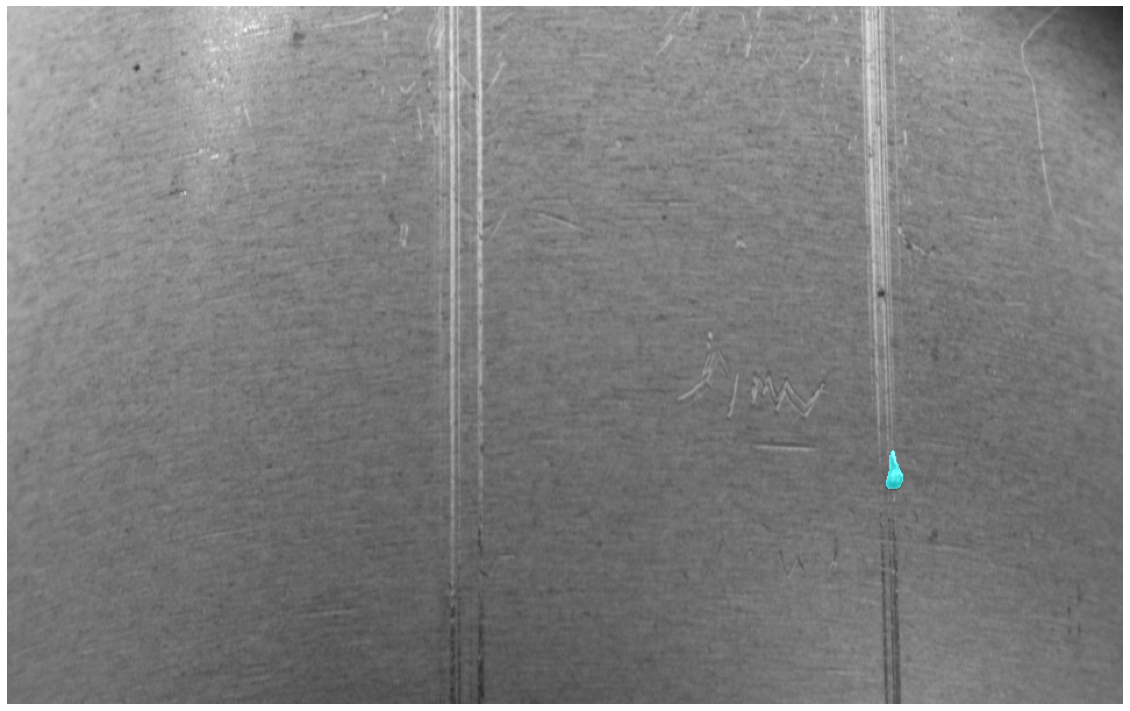

  1%|          | 1/140 [00:01<02:35,  1.12s/it]

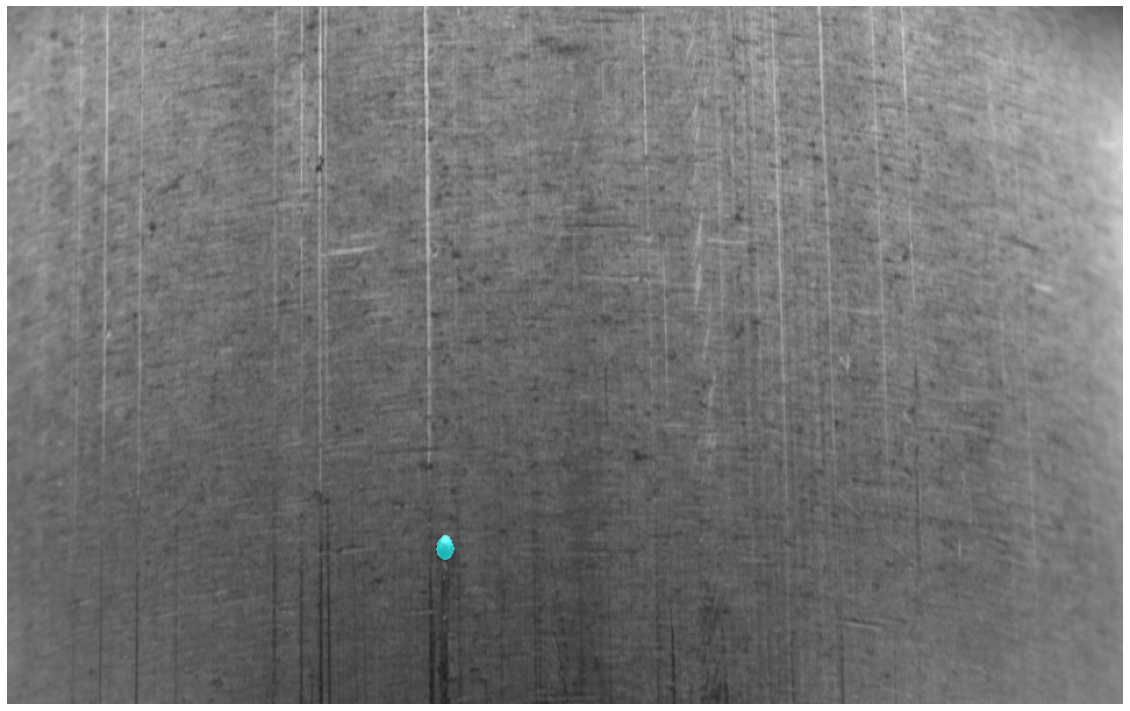

  1%|▏         | 2/140 [00:02<02:34,  1.12s/it]

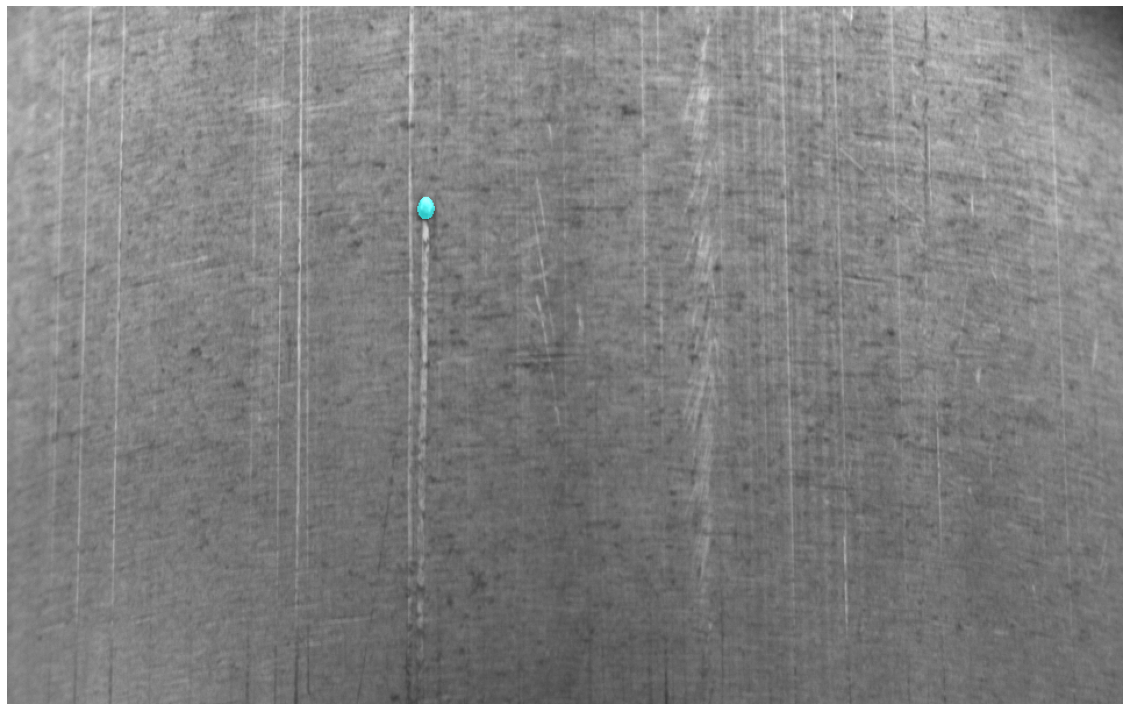

  2%|▏         | 3/140 [00:03<02:33,  1.12s/it]

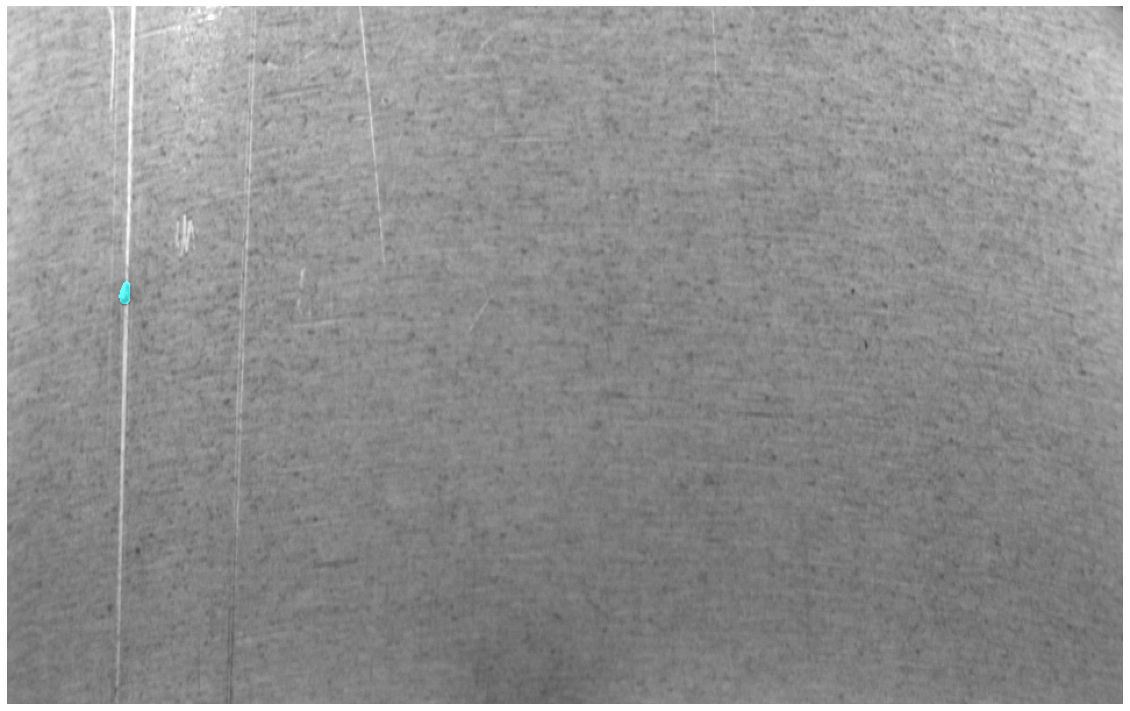

  3%|▎         | 4/140 [00:04<02:32,  1.12s/it]

KeyboardInterrupt



In [34]:
for u_image in tqdm(u_images):
    image_path = os.path.join(DATASET_ROOT, u_image)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    colored_img = image.copy()
    img_h, img_w = image.shape[:2]

    masks = np.zeros((img_h, img_w), dtype=np.uint8)
    
    img_df = df_cleared[df_cleared['filename'] == u_image]
    u_labels = img_df['class'].unique()
    
    for u_label in u_labels:        
        points = []
        labels = []

        for i, row in img_df[img_df['class'] == u_label].iterrows():
            colored_img = cv2.circle(colored_img, (row.x, row.y), radius=5, color=(255, 0, 255), thickness=-1)
            label = label2name[u_label]
            colored_img = cv2.putText(colored_img, label, (row.x - 5, row.y - 5), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 255, 0), 2)
            if row['class'] != 0:
                points.append([row.x, row.y])
                labels.append(row['class'])
        
#         if points and labels:
# #             x, y = np.array(points)[0]
# #             box = np.array([x - 10, y - 600, x + 10, y + 600])
# #             colored_img = cv2.rectangle(colored_img, (box[0], box[1]), (box[2], box[3]), color=(255, 0, 255), thickness=2)
#             predictor.set_image(image)
#             mask, _, _ = predictor.predict(
#                 point_coords=np.array(points),
#                 point_labels=np.array(labels),
#                 box=None, #box,
#                 multimask_output=True,
#             )
#             masks[mask[0]] = u_label
    
#     mask = np.stack([np.zeros_like(masks), masks, masks]).transpose(1, 2, 0) * 18
#     colored_img = draw_mask(colored_img, mask, 0.65)
    show_images([colored_img], figsize=(20, 20))
#     break
#     image_name = u_image.replace('/', '_').replace(' ', '_')
#     cv2.imwrite(os.path.join(OUT_IMAGES_FOLDER, image_name), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
#     cv2.imwrite(os.path.join(OUT_OVERLAPPED_FOLDER, image_name), cv2.cvtColor(colored_img, cv2.COLOR_RGB2BGR))
#     cv2.imwrite(os.path.join(OUT_MASKS_FOLDER, image_name), masks)

In [7]:
CSV_PATH = os.path.join(DATASET_ROOT, 'filtered_dataset.csv')
df = pd.read_csv(CSV_PATH, index_col=0)
df = df[df['stage'] == 'test']
df

,filename,x,y,class,stage
7,FRAMES/0/1538/frame0009.bmp,576,313,3,test
8,FRAMES/0/1538/frame0009.bmp,724,509,3,test
13,FRAMES/0/1538/frame0012.bmp,279,326,3,test
14,FRAMES/0/1538/frame0012.bmp,432,503,3,test
16,FRAMES/0/1538/frame0013.bmp,242,331,3,test
...,...,...,...,...,...
33463,FRAMES/2023.10.25/5_498.bmp,493,364,1,test
33536,FRAMES/2023.10.25/5_809.bmp,267,371,8,test
33563,FRAMES/2023.10.25/5_882.bmp,254,95,1,test
33564,FRAMES/2023.10.25/5_882.bmp,250,255,1,test


In [22]:
out = defaultdict(list)
u_images = df['filename'].unique()

for u_image in tqdm(u_images):
    image_path = os.path.join(DATASET_ROOT, u_image)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    colored_img = image.copy()
    img_h, img_w = image.shape[:2]

    masks = np.zeros((img_h, img_w), dtype=np.uint8)
    
    img_df = df[df['filename'] == u_image]
    u_labels = img_df['class'].unique()
    
    for u_label in u_labels:        
        points = []
        labels = []

        for i, row in img_df[img_df['class'] == u_label].iterrows():
            if row['class'] != 0:
                points.append([row.x, row.y])
                labels.append(row['class'])
        
        if points and labels:
            predictor.set_image(image)
            mask, _, _ = predictor.predict(
                point_coords=np.array(points),
                point_labels=np.array(labels),
                box=None, #box,
                multimask_output=True,
            )
            masks[mask[0]] = u_label
            
            cnts = cv2.findContours(mask[0].astype(np.uint8) * 255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)

            for c in cnts:
                M = cv2.moments(c)
                if M["m00"] == 0:
                    continue
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                
                out['filename'].append(u_image)
                out['class'].append(u_label)
                out['x'].append(cX)
                out['y'].append(cY)

100%|██████████| 908/908 [10:29<00:00,  1.44it/s]


In [25]:
result_df = pd.DataFrame(data=out)
result_df.to_csv('gt_segments.csv')